In [26]:
# Imports

from scipy import stats 
import numpy as np
import math
from math import e
from math import factorial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sn

#Import scikit-learn dataset library
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

#Regressão Linear
import statsmodels.api as sm # Importe da biblioteca

In [2]:
dados = pd.read_excel('carros.xlsx')

# REMOVENDO COLUNAS QUE FORAM JULGADAS DESNECESSARIAS
dados.drop(["seller_type", "no_of_cylinders", "regional_specs", "steering_side", "color", "emirate","motors_trim","model"], axis=1, inplace=True)


# FILTRANDO AS MARCAS QUE SERAM UTILIZADAS
# marcas = ['nissan', 'audi', 'mercedes-benz', 'lamborghini', 'maserati', 'bmw', 'bentley','ferrari']
marcas = ['ford', 'chevrolet', 'fiat', 'honda'] # Já que as outras marcas deixavam nossos preços com uma variedade gigantesca, optamos por mudar para marcas com preços mais padronizados
dados = dados.loc[dados.company.isin(marcas),:]


# DEFININDO VARIAVEIS
preco = dados['price_in_aed'].apply(lambda x: float(x.replace(".","").replace(",","")))


dados['price_in_aed'] = preco
marca = dados['company']
condicao = dados['body_condition']
tipo = dados['body_type']
transmissao = dados['transmission_type']
cavalos = dados['horsepower']
ano = dados['year']
km = dados['kilometers']
combustivel = dados['fuel_type']
mecanico = dados['mechanical_condition']


# Por conta de alguns casos particulares, usamos esse filtro para padronizar os valores
dados = dados.loc[dados['kilometers']<400000,:] # tirar os casos de carros com quilometragens absurdas
dados = dados.loc[dados['price_in_aed']<1099000,:] # tinha 1 carro que era muito mais caro que todos os outros
dados = dados.loc[dados['horsepower']!='Unknown',:] # alguns carros tinham o horsepowe indefinido, aqui estamos filtrando eles
dados = dados.loc[dados['year'].isnull()==False,:] # Tirando valores nulos da coluna ano


# Pouco Exemplo
dados = dados.loc[dados['body_type']!='Utility Truck']
dados = dados.loc[dados['body_type']!='Van']
dados = dados.loc[dados['body_type']!='Wagon']
dados = dados.loc[dados['body_type']!='Other']

dados = dados.loc[dados['body_condition']!=('Normal wear & tear, a few issues'),:]
dados = dados.loc[dados['horsepower']!=('600 - 700 HP'),:]
dados = dados.loc[dados['horsepower']!=('900+ HP'),:]
dados = dados.loc[dados['horsepower']!=('700 - 800 HP'),:]

dados = dados.loc[dados['fuel_type']!=('Electric'),:]
dados = dados.loc[dados['fuel_type']!=('Diesel'),:]
dados = dados.loc[dados['fuel_type']!=('Hybrid'),:]

# Ja que o combustivel que estamos considerando é só Gasolina, tiramos a coluna "fuel_type"
dados.drop(['fuel_type'], axis=1, inplace=True)

In [3]:
dados.head(5)

,title,price_in_aed,kilometers,body_condition,mechanical_condition,body_type,transmission_type,horsepower,year,company,date_posted
1,chevrolet silverado,110000.0,39000,Perfect inside and out,Perfect inside and out,SUV,Automatic Transmission,400 - 500 HP,2018.0,chevrolet,14/01/2022
29,2021 FORD MUSTANG GT PREMIUM V8 5.0L GCC 0Km W...,245999.0,7,Perfect inside and out,Perfect inside and out,Hard Top Convertible,Automatic Transmission,400 - 500 HP,2021.0,ford,30/04/2022
36,Inspected Car | 2014 Chevrolet Traverse LTZ 3....,36000.0,162579,Perfect inside and out,Perfect inside and out,SUV,Automatic Transmission,200 - 300 HP,2014.0,chevrolet,26/04/2022
60,Inspected Car | 2013 Ford Edge Sport 3.7L | GC...,37000.0,199575,Perfect inside and out,Perfect inside and out,SUV,Automatic Transmission,300 - 400 HP,2013.0,ford,18/03/2022
66,"4,410 / month | 0% Down Payment | Camaro SS / ...",219000.0,8800,Perfect inside and out,Perfect inside and out,Coupe,Automatic Transmission,400 - 500 HP,2021.0,chevrolet,23/11/2021


In [4]:
dados.isnull().sum() # Para ver se tem alguma celula vazia no df

title                   0
price_in_aed            0
kilometers              0
body_condition          0
mechanical_condition    0
body_type               0
transmission_type       0
horsepower              0
year                    0
company                 0
date_posted             0
dtype: int64

O código acima mostra se existe alguma váriavel com o valor 0, precisavamos saber, pois caso existisse algum valor nulo, iria travar nosso código futuramente

----
## Definindo faixas de preços
##### Já que nossa base de dados tem VARIOS preços, ao utilizar faixas de preço ao invés de um por um, podemos facilitar o processo

In [5]:
faixas = np.linspace(5000,540000,20)

dados['precoFaixa'] = pd.cut(preco, bins=faixas)

dados['precoFaixa']

1        (89473.684, 117631.579]
29      (230263.158, 258421.053]
36        (33157.895, 61315.789]
60        (33157.895, 61315.789]
66      (202105.263, 230263.158]
                  ...           
9880    (202105.263, 230263.158]
9884      (61315.789, 89473.684]
9918      (33157.895, 61315.789]
9932      (61315.789, 89473.684]
9968         (5000.0, 33157.895]
Name: precoFaixa, Length: 840, dtype: category
Categories (19, interval[float64, right]): [(5000.0, 33157.895] < (33157.895, 61315.789] < (61315.789, 89473.684] < (89473.684, 117631.579] ... (427368.421, 455526.316] < (455526.316, 483684.211] < (483684.211, 511842.105] < (511842.105, 540000.0]]

----
## Vendo as correlações


In [6]:
# CONFIRMAR
print(preco.corr(km)) # quanto menor a quilometragem maior o preco
print(preco.corr(ano)) # quanto mais novo o carro maior o preco
dados.corr()

-0.3348467477894393
0.18863883292534722


,price_in_aed,kilometers,year
price_in_aed,1.000000,-0.551618,0.269896
kilometers,-0.551618,1.000000,-0.344931
year,0.269896,-0.344931,1.000000



### Preço x Marca

<AxesSubplot:xlabel='company', ylabel='price_in_aed'>

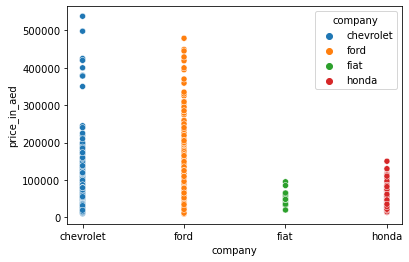

In [7]:
sns.scatterplot(data=dados, x="company", y=preco, hue= dados['company'])

Com esse gráfico, conseguimos ver quais são as marcas que atingem o maior valor

In [8]:
companhiaPreco = dados.groupby(dados['company'])['price_in_aed'].describe()
companhiaPreco

,count,mean,std,min,25%,50%,75%,max
company,,,,,,,,
chevrolet,237.0,92546.991561,86858.518345,9900.0,35000.0,68000.0,118000.0,538000.0
fiat,14.0,51657.142857,20942.878881,19500.0,35750.0,48000.0,63575.0,95000.0
ford,463.0,100827.455724,90226.625980,9000.0,36500.0,68000.0,135000.0,479000.0
honda,126.0,53822.031746,27634.000426,13500.0,30000.0,49999.5,71975.0,149999.0


Confirmamos a informação do gráfico com o groupby

###### BoxPlot sugerido pela Kelly

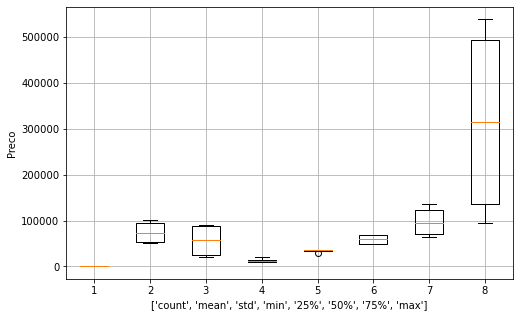

In [9]:
plt.figure(figsize=(8,5))
plt.boxplot(companhiaPreco)
plt.xlabel(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
plt.ylabel('Preco')
plt.grid()
plt.show()

----
### Preço x Condição

In [10]:
corpoPreco = dados.groupby(dados['body_condition'])['price_in_aed'].describe()
corpoPreco

,count,mean,std,min,25%,50%,75%,max
body_condition,,,,,,,,
"A bit of wear & tear, all repaired",18.0,46011.111111,26156.472349,9000.0,33500.0,41350.0,59500.0,120000.0
"No accidents, very few faults",26.0,60795.961538,45334.277363,11000.0,27000.0,62000.0,79000.0,225000.0
Perfect inside and out,796.0,92603.806533,85108.931909,9900.0,35000.0,63900.0,117250.0,538000.0


Confirmando que os carros que estão perfeitos tanto dentro quanto fora, são os mais caros e os que aparecem na planilha.

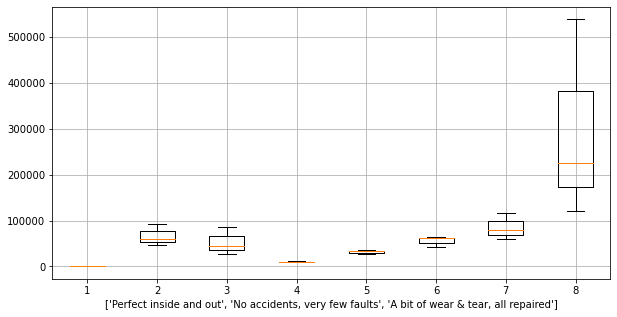

In [11]:
bodytype = []
for tipo in dados['body_condition']:
    if tipo not in bodytype:
        bodytype.append(tipo)
len(bodytype)

plt.figure(figsize=(10,5))
plt.boxplot(corpoPreco)
plt.xlabel(bodytype)
plt.grid()
plt.show()

----
### Preço x Tipo

In [12]:
dados.groupby(dados['body_type'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
body_type,,,,,,,,
Coupe,86.0,92339.523256,71804.318915,23000.0,52375.0,68500.0,114750.0,379900.0
Crossover,10.0,60840.000000,37463.617907,27500.0,32500.0,59450.0,65375.0,155000.0
Hard Top Convertible,16.0,217987.437500,158677.589570,19500.0,100500.0,185000.0,302750.0,538000.0
Hatchback,48.0,34131.229167,17710.371639,11800.0,19375.0,32700.0,44900.0,85000.0
Pick Up Truck,124.0,159580.274194,102246.972856,28000.0,84425.0,140995.0,205000.0,479000.0
SUV,331.0,84989.084592,73065.925996,11000.0,35000.0,58000.0,103300.0,359000.0
Sedan,149.0,39979.778523,20852.625265,9000.0,24500.0,35000.0,52000.0,128900.0
Soft Top Convertible,18.0,107888.888889,72768.479673,13000.0,63375.0,81250.0,123750.0,293000.0
Sports Car,58.0,114267.241379,83397.810960,39000.0,72750.0,89500.0,118750.0,425000.0


Vendo como o body_type pode afetar o preço do carro, e vendo quantas vezes cada corpo aparece, assim podendo tirar da base de dados caso algum apareca muito pouco

----
### Preço x Tipo de Transmissão

In [13]:
dados.groupby(dados['transmission_type'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
transmission_type,,,,,,,,
Automatic Transmission,804.0,90956.747512,84430.504442,9000.0,35000.0,62000.0,114992.5,538000.0
Manual Transmission,36.0,83119.444444,67057.603466,19500.0,35750.0,63000.0,95750.0,350000.0


Ver a diferença entre a quantidade de modelos automaticos e manuais, e a diferença de preços entre eles.

----
### Preço x Cavalos

In [14]:
dados.groupby(dados['horsepower'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
horsepower,,,,,,,,
150 - 200 HP,145.0,42952.993103,22470.943542,11800.0,26900.0,37000.0,55000.0,128900.0
200 - 300 HP,233.0,66926.326180,59112.982774,11000.0,33000.0,48500.0,75000.0,350000.0
300 - 400 HP,235.0,97856.702128,66778.241704,14000.0,50750.0,80000.0,125000.0,325000.0
400 - 500 HP,144.0,168814.486111,111041.208954,21500.0,92250.0,134000.0,210000.0,538000.0
500 - 600 HP,24.0,196374.958333,130143.990115,9000.0,98000.0,166000.0,256750.0,429000.0
Less than 150 HP,59.0,38659.271186,20035.596913,9900.0,23150.0,32900.0,48999.5,85000.0


----
### Preço x Ano

In [15]:
dados.groupby(dados['year'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1960.0,1.0,350000.000000,NaN,350000.0,350000.0,350000.0,350000.0,350000.0
1965.0,2.0,236500.000000,79903.066274,180000.0,208250.0,236500.0,264750.0,293000.0
1971.0,2.0,130000.000000,7071.067812,125000.0,127500.0,130000.0,132500.0,135000.0
1973.0,1.0,160000.000000,NaN,160000.0,160000.0,160000.0,160000.0,160000.0
1975.0,1.0,110000.000000,NaN,110000.0,110000.0,110000.0,110000.0,110000.0
1979.0,1.0,95000.000000,NaN,95000.0,95000.0,95000.0,95000.0,95000.0
1990.0,1.0,38000.000000,NaN,38000.0,38000.0,38000.0,38000.0,38000.0
2001.0,1.0,57800.000000,NaN,57800.0,57800.0,57800.0,57800.0,57800.0
2002.0,1.0,19500.000000,NaN,19500.0,19500.0,19500.0,19500.0,19500.0


----
### Preço x Km

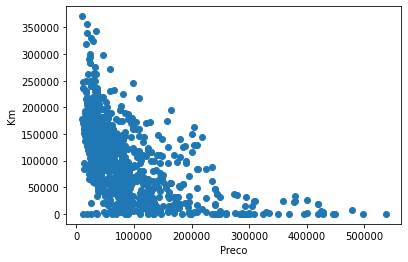

In [16]:
# sns.scatterplot(data=dados, x="company", y=preco, hue= dados['company'])


# CONFIRMAR C VALE A PENA USAR ESSE GRAFICO
plt.scatter(dados['price_in_aed'],dados['kilometers'])
plt.xlabel('Preco')
plt.ylabel('Km')
plt.show()

In [17]:
#anoQuilometragem = dados.kilometers.corr(dados.year)

precoQuilometragem = preco.corr(dados.kilometers) 
print(precoQuilometragem)


-0.5516178757132725


Quanto menor a quilometragem maior o preco

----
# Analise de dados

In [18]:
dados = pd.read_excel('carros.xlsx', dtype={'body_type':'category', 'body_condition':'category', 'company': 'category', 'transmission_type': 'category', 'horsepower': 'category','fuel_type': 'category', 'mechanical_condition': 'category', 'company': 'category' })

# REMOVENDO COLUNAS QUE FORAM JULGADAS DESNECESSARIAS
dados.drop(["seller_type", "no_of_cylinders", "regional_specs", "steering_side", "color", "emirate","motors_trim","model"], axis=1, inplace=True)


# FILTRANDO AS MARCAS QUE SERAM UTILIZADAS
# marcas = ['nissan', 'audi', 'mercedes-benz', 'lamborghini', 'maserati', 'bmw', 'bentley','ferrari']
marcas = ['ford', 'chevrolet', 'fiat', 'honda'] # Já que as outras marcas deixavam nossos preços com uma variedade gigantesca, optamos por mudar para marcas com preços mais padronizados
dados = dados.loc[dados.company.isin(marcas),:]


# DEFININDO VARIAVEIS
preco = dados['price_in_aed'].apply(lambda x: float(x.replace(".","").replace(",","")))

dados['price_in_aed'] = preco
marca = dados['company']
condicao = dados['body_condition']
tipo = dados['body_type']
transmissao = dados['transmission_type']
cavalos = dados['horsepower']
ano = dados['year']
km = dados['kilometers']
combustivel = dados['fuel_type']
mecanico = dados['mechanical_condition']


# Por conta de alguns casos particulares, usamos esse filtro para padronizar os valores
dados = dados.loc[dados['kilometers']<400000,:] # tirar os casos de carros com quilometragens absurdas
dados = dados.loc[dados['price_in_aed']<1099000,:] # tinha 1 carro que era muito mais caro que todos os outros
dados = dados.loc[dados['horsepower']!='Unknown',:] # alguns carros tinham o horsepowe indefinido, aqui estamos filtrando eles
dados = dados.loc[dados['year'].isnull()==False,:] # Tirando valores nulos da coluna ano


# Pouco Exemplo
dados = dados.loc[dados['body_type']!='Utility Truck']
dados = dados.loc[dados['body_type']!='Van']
dados = dados.loc[dados['body_type']!='Wagon']
dados = dados.loc[dados['body_type']!='Other']

dados = dados.loc[dados['body_condition']!=('Normal wear & tear, a few issues'),:]
dados = dados.loc[dados['horsepower']!=('600 - 700 HP'),:]
dados = dados.loc[dados['horsepower']!=('900+ HP'),:]
dados = dados.loc[dados['horsepower']!=('700 - 800 HP'),:]

dados = dados.loc[dados['fuel_type']!=('Electric'),:]
dados = dados.loc[dados['fuel_type']!=('Diesel'),:]
dados = dados.loc[dados['fuel_type']!=('Hybrid'),:]


# Ja que o combustivel que estamos considerando é só Gasolina, tiramos a coluna "fuel_type"
dados.drop(['fuel_type'], axis=1, inplace=True)


# Transformando as variaveis em valores numericos
dados['Corpo'] = dados['body_type'].cat.codes
dados['Condicao Corpo'] = dados['body_condition'].cat.codes
dados['Condicao Mecanica'] = dados['mechanical_condition'].cat.codes
dados['Transmissao'] = dados['transmission_type'].cat.codes
dados['Cavalos'] = dados['horsepower'].cat.codes
dados['Marcas'] = dados['company'].cat.codes

#colocando as faixas de preço novamente
faixas = np.linspace(5000,540000,20)

dados['precoFaixa'] = pd.cut(preco, bins=faixas)


In [19]:
dados.corr()

,price_in_aed,kilometers,year,Corpo,Condicao Corpo,Condicao Mecanica,Transmissao,Cavalos,Marcas
price_in_aed,1.000000,-0.551618,0.269896,-0.065818,0.102710,0.068080,-0.018966,0.093446,-0.103418
kilometers,-0.551618,1.000000,-0.344931,0.076121,-0.096545,-0.076393,-0.042908,-0.071035,0.059473
year,0.269896,-0.344931,1.000000,0.054692,0.084065,0.134711,-0.170622,0.082422,0.001693
Corpo,-0.065818,0.076121,0.054692,1.000000,-0.045694,-0.015940,-0.156243,-0.047560,0.073511
Condicao Corpo,0.102710,-0.096545,0.084065,-0.045694,1.000000,0.374755,-0.015618,0.026423,-0.034938
Condicao Mecanica,0.068080,-0.076393,0.134711,-0.015940,0.374755,1.000000,-0.024059,0.005429,0.006797
Transmissao,-0.018966,-0.042908,-0.170622,-0.156243,-0.015618,-0.024059,1.000000,0.025757,-0.011948
Cavalos,0.093446,-0.071035,0.082422,-0.047560,0.026423,0.005429,0.025757,1.000000,-0.098902
Marcas,-0.103418,0.059473,0.001693,0.073511,-0.034938,0.006797,-0.011948,-0.098902,1.000000


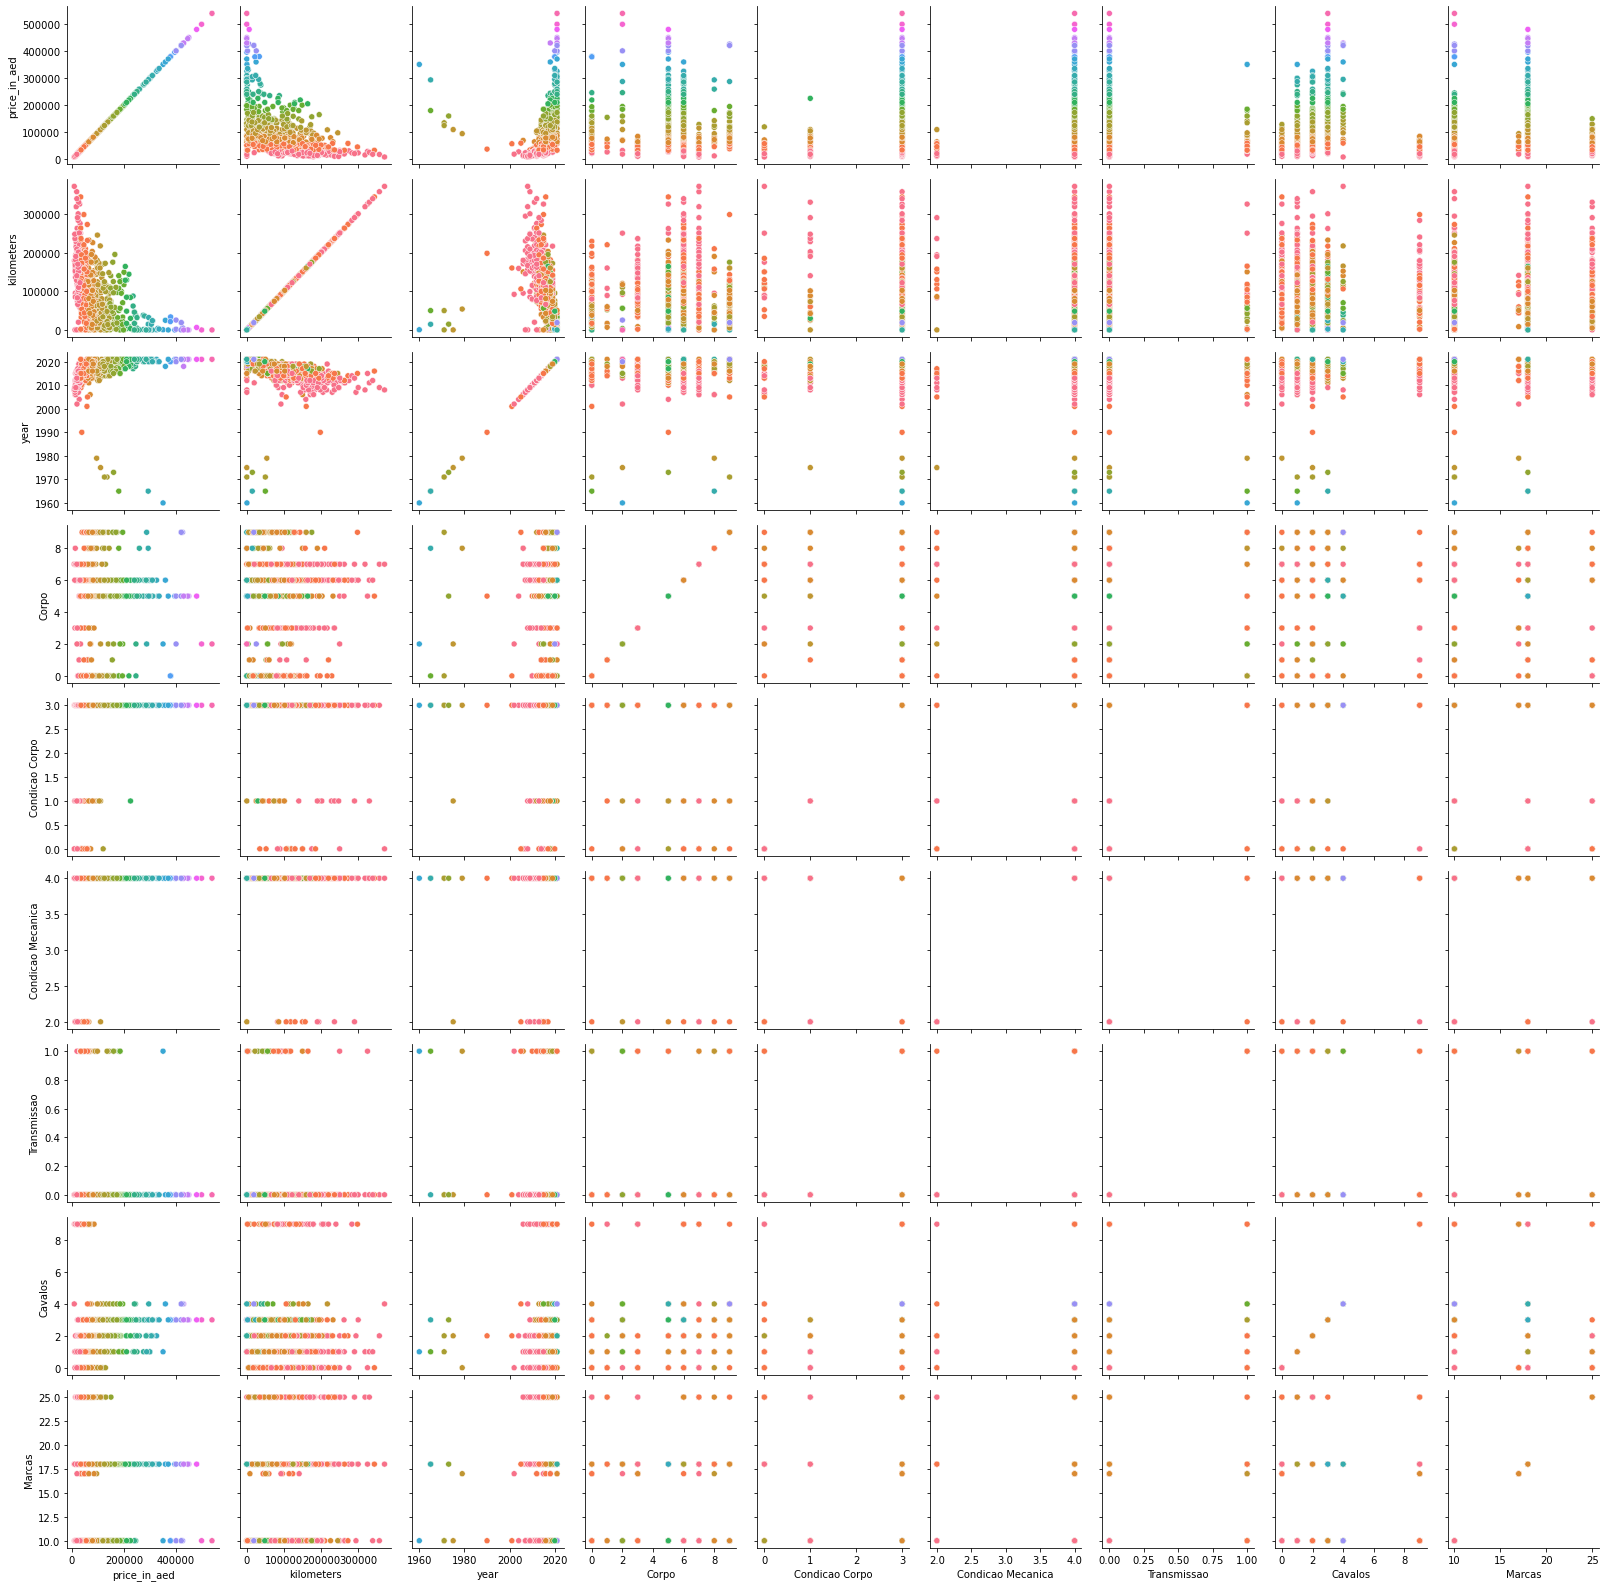

In [71]:
x = sns.PairGrid(dados, hue='precoFaixa', height=2.5)
x.map(sns.scatterplot)
# Cada cor de bolinhas nesse grafico é uma faixa de preço

In [20]:
X=dados[['Marcas','Condicao Corpo','Corpo','Transmissao','Cavalos','year','kilometers','Condicao Mecanica']]  # Features
y=dados['price_in_aed']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

iris = datasets.load_iris()

iris.feature_names = ['Marcas','Condicao Corpo','Corpo','Transmissao','Cavalos','year','kilometers','Condicao Mecanica']
iris.target_names = ['precoFaixa']

In [21]:
feature_imp = pd.Series(clf.feature_importances_,index=iris.feature_names).sort_values(ascending=False)
feature_imp

kilometers           0.427174
year                 0.206623
Corpo                0.131779
Cavalos              0.111162
Marcas               0.077756
Condicao Corpo       0.024635
Transmissao          0.014567
Condicao Mecanica    0.006304
dtype: float64

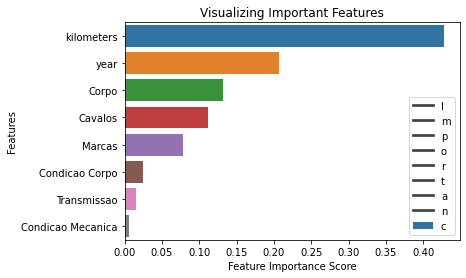

In [22]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend('Importancia de ')
plt.show()

## Histogramas

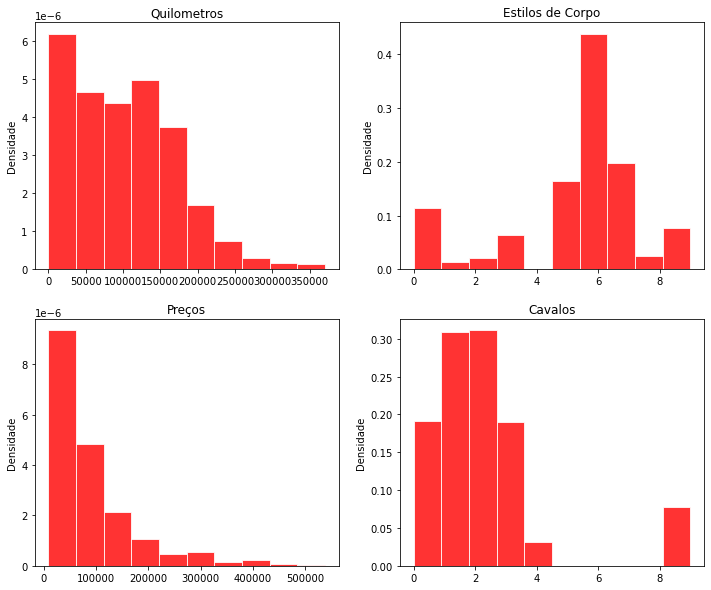

In [23]:
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.hist(dados["kilometers"], density=True, color='red', edgecolor='white', linewidth=1, alpha=0.8)
plt.title('Quilometros')
plt.ylabel('Densidade')
plt.ylim=(0,0.2)

plt.subplot(222)
plt.hist(dados["Corpo"], density=True, color='red', edgecolor='white', linewidth=1, alpha=0.8)
plt.title('Estilos de Corpo')
plt.ylabel('Densidade')
plt.ylim=(0,0.2)

plt.subplot(223)
plt.hist(dados["price_in_aed"], density=True, color='red', edgecolor='white', linewidth=1, alpha=0.8)
plt.title('Preços')
plt.ylabel('Densidade')
plt.ylim=(0,0.2)

plt.subplot(224)
plt.hist(dados["Cavalos"], density=True, color='red', edgecolor='white', linewidth=1, alpha=0.8)
plt.title('Cavalos')
plt.ylabel('Densidade')
plt.ylim=(0,0.2)

plt.show()

# Predição por Regressão Logistica Simples

In [32]:
X=dados[['Marcas','Condicao Corpo','Corpo','Transmissao','Cavalos','year','kilometers','Condicao Mecanica']]  # Features
y=dados['price_in_aed']  # Labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [33]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [34]:
X_dados = sm.add_constant(X_train) # Adiciona coluna de 1s para estimar intercepto junto com a coluna de x (dados)

# Define o modelo
model = sm.OLS(y_train, X_dados)    

# Faz o ajuste
results = model.fit()   

# Mostra os resultados
results.summary()    

C:\Users\55119\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_in_aed   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     39.83
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           2.88e-51
Time:                        08:04:46   Log-Likelihood:                -7880.6
No. Observations:                 630   AIC:                         1.578e+04
Df Residuals:                     621   BIC:                         1.582e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -7.127e+06   1.34e+06     -5.335      0.000   -9.75e+06    -4.5e+06
Marcas             -620.2791    543.583     -1.141      0.254   -1687.763     447.205
Condicao Corpo     2933.4551   5505.503      0.533      0.594   -7878.204    1.37e+04
Corpo             -1144.4759   1192.471     -0.960      0.338   -3486.241    1197.289
Transmissao       -4625.0998   1.37e+04     -0.338      0.735   -3.15e+04    2.22e+04
Cavalos            1199.8049   1187.950      1.010      0.313   -1133.081    3532.691
year               3621.5774    665.079      5.445      0.000    2315.500    4927.654
kilometers           -0.4946      0.042    -11.706      0.000      -0.578      -0.412
Condicao Mecanica -7555.2531   1.23e+04     -0.615      0.539   -3.17e+04    1.66e+04
==============================================================================
Omnibus:                      242.744   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              909.682
Skew:                           1.795   Prob(JB):                    2.92e-198
Kurtosis:                       7.665   Cond. No.                     6.27e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Tirando os valores de P altos

In [35]:
valor_p = (results.pvalues)
valor_p.sort_values(ascending=False)

Transmissao          7.351097e-01
Condicao Corpo       5.943472e-01
Condicao Mecanica    5.388306e-01
Corpo                3.375540e-01
Cavalos              3.128986e-01
Marcas               2.542708e-01
const                1.337345e-07
year                 7.456782e-08
kilometers           9.631672e-29
dtype: float64

In [37]:
X = dados[['Marcas','Condicao Corpo','Corpo','Transmissao','Cavalos','year','kilometers']]
y = dados['price_in_aed']
results = regress(y,X)
results.summary()
valor_p = (results.pvalues)
valor_p.sort_values(ascending=False)

C:\Users\55119\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Corpo             3.415720e-01
Transmissao       2.719920e-01
Condicao Corpo    1.525816e-01
Cavalos           1.438133e-01
Marcas            2.248496e-02
const             1.343057e-02
year              8.269967e-03
kilometers        1.469075e-53
dtype: float64

In [38]:
X = dados[['Marcas','Condicao Corpo','Transmissao','Cavalos','year','kilometers']]
y = dados['price_in_aed']
results = regress(y,X)
results.summary()
valor_p = (results.pvalues)
valor_p.sort_values(ascending=False)

C:\Users\55119\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Transmissao       3.291067e-01
Condicao Corpo    1.408539e-01
Cavalos           1.342363e-01
Marcas            1.898080e-02
const             1.536050e-02
year              9.654863e-03
kilometers        2.986352e-54
dtype: float64

In [39]:
X = dados[['Marcas','Condicao Corpo','Cavalos','year','kilometers']]
y = dados['price_in_aed']
results = regress(y,X)
results.summary()
valor_p = (results.pvalues)
valor_p.sort_values(ascending=False)

C:\Users\55119\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Cavalos           1.432310e-01
Condicao Corpo    1.382224e-01
Marcas            1.905964e-02
const             7.559025e-03
year              4.553810e-03
kilometers        3.193992e-54
dtype: float64

In [40]:
X = dados[['Marcas','Condicao Corpo','Transmissao','year','kilometers']]
y = dados['price_in_aed']
results = regress(y,X)
results.summary()
valor_p = (results.pvalues)
valor_p.sort_values(ascending=False)

C:\Users\55119\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Transmissao       3.562860e-01
Condicao Corpo    1.356067e-01
Marcas            1.245389e-02
const             1.154706e-02
year              7.023499e-03
kilometers        1.586953e-54
dtype: float64

In [41]:
X = dados[['Marcas','Condicao Corpo','year','kilometers']]
y = dados['price_in_aed']
results = regress(y,X)
results.summary()
valor_p = (results.pvalues)
valor_p.sort_values(ascending=False)

C:\Users\55119\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Condicao Corpo    1.332824e-01
Marcas            1.261076e-02
const             5.750002e-03
year              3.352804e-03
kilometers        1.526958e-54
dtype: float64

In [45]:
X = dados[['Marcas','year','kilometers']]
y = dados['price_in_aed']
results = regress(y,X)
results.summary()
valor_p = (results.pvalues)
valor_p.sort_values(ascending=False)
results.summary()

C:\Users\55119\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_in_aed   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     129.2
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           9.18e-69
Time:                        08:12:48   Log-Likelihood:                -10553.
No. Observations:                 840   AIC:                         2.111e+04
Df Residuals:                     836   BIC:                         2.113e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.521e+06   8.91e+05     -2.830      0.005   -4.27e+06   -7.72e+05
Marcas     -1247.6236    490.140     -2.545      0.011   -2209.673    -285.574
year        1336.4789    441.529      3.027      0.003     469.842    2203.115
kilometers    -0.6089      0.036    -16.890      0.000      -0.680      -0.538
==============================================================================
Omnibus:                      309.520   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1132.368
Skew:                           1.751   Prob(JB):                    1.29e-246
Kurtosis:                       7.481   Cond. No.                     4.57e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.57e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
  X = dados[['year','kilometers']]
y = dados['price_in_aed']
results = regress(y,X)
results.summary()
valor_p = (results.pvalues)
valor_p.sort_values(ascending=False)
results.summary()

C:\Users\55119\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_in_aed   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     189.3
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.47e-68
Time:                        08:13:03   Log-Likelihood:                -10556.
No. Observations:                 840   AIC:                         2.112e+04
Df Residuals:                     837   BIC:                         2.113e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.488e+06   8.94e+05     -2.783      0.006   -4.24e+06   -7.34e+05
year        1309.8416    442.848      2.958      0.003     440.619    2179.064
kilometers    -0.6148      0.036    -17.032      0.000      -0.686      -0.544
==============================================================================
Omnibus:                      315.729   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.165
Skew:                           1.780   Prob(JB):                    1.20e-257
Kurtosis:                       7.597   Cond. No.                     4.57e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.57e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Como nosso R-squared não chegou perto de 1, concluimos que o modelo não se encaixa muito bem em nossa base de dados, outro fato é que a váriavel 'Marcas' é importante para o modelo. Portanto o melhor aproveitamento dessa predição seria:


X = dados[['Marcas','year','kilometers']]


y = dados['price_in_aed']


results = regress(y,X)


valor_p = (results.pvalues)


valor_p.sort_values(ascending=False)

----
## Naive Bayes

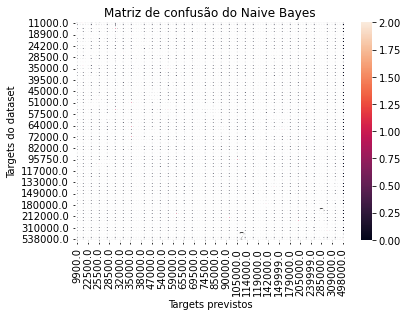

In [48]:
#Cria um classificador Gaussiano
classifier = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

#Treina o modelo usando os dados de treino 
classifier.fit(X_train, y_train)

#Resultado de previsão 
naives_bayes_predict = classifier.predict(X_test)
cm = pd.crosstab(y_test, naives_bayes_predict, rownames=['Targets do dataset'], colnames=['Targets previstos'])

ax = plt.axes()
sns.heatmap(cm, annot=True)
ax.set_title('Matriz de confusão do Naive Bayes')
plt.show()


In [49]:
acuracia = metrics.accuracy_score(y_test, naives_bayes_predict)
print("A acurácia do modelo é de: " + str(acuracia*100) + " %")

A acurácia do modelo é de: 1.9047619047619049 %


## KNN

In [50]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt



X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse



48644.97815864114

In [51]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

76260.83825740589

TypeError: '(slice(None, None, None), 0)' is an invalid key

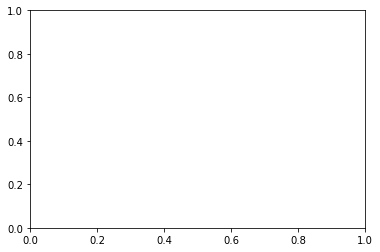

In [56]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test[:, 0], X_test[:, 1], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

----
# Conclusão

----
# Referencias

* https://www.datacamp.com/tutorial/random-forests-classifier-python
* https://www.computersciencemaster.com.br/o-que-e-regressao-logistica-e-como-aplica-la-usando-python/
